# Project Galilei
### "Measure what is measurable, and make measurable what is not so."

## Graph Representation, RW, & Embedding

    imports

In [1]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import networkx as nx
import stellargraph as sg

from gensim.models import Word2Vec, callbacks

from pyvis.network import Network

In [5]:
import pyvis

In [6]:
pyvis.__version__

'0.1.9'

    read

In [2]:
arxiv_meta = pd.read_json("../data/raw/arxiv-metadata-oai-snapshot.json", lines=True, nrows=100000)
arxiv_meta["update_date"] = pd.to_datetime(arxiv_meta["update_date"])

In [3]:
arxiv_meta.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"


    downsample

In [29]:
# downsample arxiv meta by a labeled category
# avoiding regex for now
arxiv_meta["categories_parsed"] = arxiv_meta["categories"].str.split(" ")

# isolating condensed matter
condensed_matter = arxiv_meta[["cond-mat." in x for x in arxiv_meta["categories"]]]
condensed_matter.reset_index(inplace=True, drop=True)

In [30]:
# authors parse contains empty strings, numbering of authors and occasionally contributors.
condensed_matter["authors_parsed"] = [[" ".join((y[1], y[0])) for y in x] for x in condensed_matter["authors_parsed"]]

C:\Users\mjwjl\AppData\Local\Temp/ipykernel_29048/475204135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_matter["authors_parsed"] = [[" ".join((y[1], y[0])) for y in x] for x in condensed_matter["authors_parsed"]]


In [31]:
# all authors and looking for authors that have contributed to more than 1 paper
authors_expanded = pd.Series([y for x in condensed_matter["authors_parsed"] for y in x])
repeat_authors = list(authors_expanded.value_counts()[(authors_expanded.value_counts() > 1)].index)

# filtering condensed matter using intersection between the set of papers authors(~2-5) and a set of
# repeat authors(~2.1 * df.shape[0], where 2.5 is the mean number of papers authors have written)
condensed_matter = condensed_matter[[set(condensed_matter["authors_parsed"].iloc[i]) & set(repeat_authors) != set() for i in condensed_matter.index]]
condensed_matter.reset_index(inplace=True, drop=True)

In [7]:
# all authors and looking for authors that have contributed to more than 2 paper
# authors_expanded = pd.Series([y for x in condensed_matter["authors_parsed"] for y in x])
# serial_authors = list(authors_expanded.value_counts()[(authors_expanded.value_counts() > 2)].index)

# filtering condensed matter using intersection between the set of papers authors(~2-5) and a set of
# serial authors(~2.1 * df.shape[0], where 2.5 is the mean number of papers authors have written)
# condensed_matter = condensed_matter[[set(condensed_matter["authors_parsed"].iloc[i]) & set(serial_authors) != set() for i in condensed_matter.index]]
# condensed_matter.reset_index(inplace=True, drop=True)

Futher restricting dataset to authors with 3 or more papers published.

### Create Graphs

Papers are weighted based on the number of authors they share. This results in graph representation of colleagues, universities, and regions.

In [180]:
# https://stellargraph.readthedocs.io/en/v1.0.0rc1/demos/embeddings/stellargraph-metapath2vec.html#Representation-Learning-using-Word2Vec
# creates tuple if authors 

# nodes_edge_weight_list = []
# upper_bound = condensed_matter.shape[0]

# for i in range(upper_bound):
#     for j in range(i+1, upper_bound):
#         if len(set(condensed_matter["authors_parsed"].iloc[i]) & set(condensed_matter["authors_parsed"].iloc[j])) != 0:
#             k = len(set(condensed_matter["authors_parsed"].iloc[i]) & set(condensed_matter["authors_parsed"].iloc[j]))

#             nodes_edge_weight_list.append((i, j, k))
            
#     if i % 500 == 0:
#         print(f"i is equal to {i} iteration {i * j} complete")

In [200]:
# with open("../models/graph_edges_2plus.pkl", "wb") as file:
#     pickle.dump(nodes_edge_weight_list, file)

In [12]:
with open("../models/graph_models/graph_edges_2plus.pkl", "rb") as file:
    nd_ed_wg = pickle.load(file)

In [9]:
# https://stellargraph.readthedocs.io/en/v1.0.0rc1/demos/embeddings/stellargraph-metapath2vec.html#Representation-Learning-using-Word2Vec
# nodes_edge_weight_list_serial = []
# upper_bound = condensed_matter.shape[0]

# for i in range(upper_bound):
#     for j in range(i+1, upper_bound):
#         if len(set(condensed_matter["authors_parsed"].iloc[i]) & set(condensed_matter["authors_parsed"].iloc[j])) != 0:
#             k = len(set(condensed_matter["authors_parsed"].iloc[i]) & set(condensed_matter["authors_parsed"].iloc[j]))

#             nodes_edge_weight_list_serial.append((i, j, k))
            
#     if i % 500 == 0:
#         print(f"i is equal to {i} iteration {i * j} complete")

In [120]:
# with open("../models/graph_models/graph_edges_3plus.pkl", "wb") as file:
#     pickle.dump(nodes_edge_weight_list_serial, file)

In [10]:
with open("../models/graph_models/graph_edges_3plus.pkl", "rb") as file:
    nd_ed_wg_ser = pickle.load(file)

### Graph Visualizations

In [35]:
# Too large. Have to export
paper_author_paper = nx.Graph()
paper_author_paper.add_nodes_from
paper_author_paper.add_weighted_edges_from(nd_ed_wg)

In [38]:
# Papers with largest collaborations
influential_papers_500_reordered = sorted([(nd_ed_wg[i][2], nd_ed_wg[i][0], nd_ed_wg[i][1]) for i in range(len(nd_ed_wg))], reverse=True)[0:500]
# Reordered for graph creation
influential_papers_500 = [(influential_papers_500_reordered[i][1], influential_papers_500_reordered[i][2], influential_papers_500_reordered[i][0]) for i in range(len(influential_papers_500_reordered))]

In [39]:
influential_papers_500_title = [(condensed_matter["title"].iloc[i], condensed_matter["title"].iloc[j], k) for i, j, k in influential_papers_500]

In [40]:
influence = nx.Graph()
influence.add_weighted_edges_from(influential_papers_500)

In [41]:
influence_title = nx.Graph()
influence_title.add_weighted_edges_from(influential_papers_500_title)

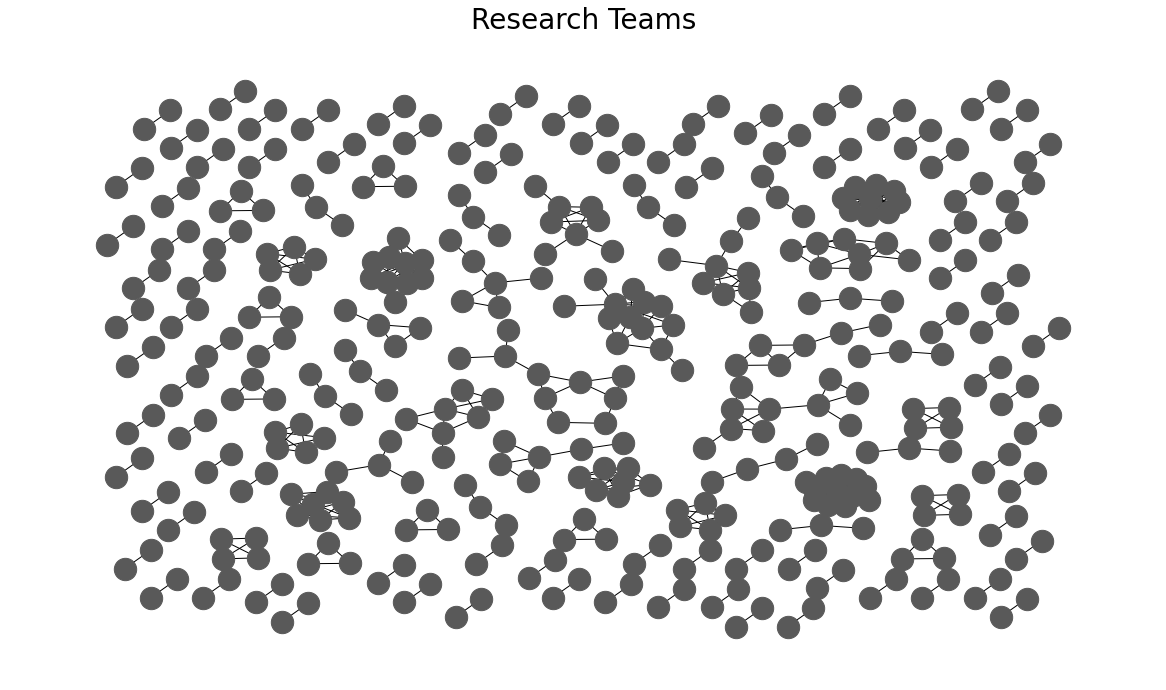

In [233]:
plt.figure(figsize=(16, 9))

pos = nx.nx_pydot.pydot_layout(influence)
nx.draw(influence, pos=pos, node_color="#595959", node_size=500, label=True)

plt.title("Research Teams", fontsize=28)

plt.savefig("../images/network_graph_influencers", transparent=True)

In [46]:
# plt.figure(figsize=(16, 9))

# nx.drawing.draw_networkx(influence_title, node_color="#595959", node_size=100, with_labels=True)

# plt.title("Top 5000 Influential Papers", fontsize=28)

# plt.savefig("../images/network_influence_title_labeled_5000_second", transparent=True)

In [51]:
well_connected = sorted(set(sorted([(len(list(paper_author_paper.neighbors(i))), (i, j, k)) for i, j, k in nd_ed_wg], reverse=True)), reverse=True)[0:5000]
well_connected = [y for x, y in well_connected]

In [52]:
well_connected_graph = nx.Graph()
well_connected_graph.add_weighted_edges_from(well_connected)

In [53]:
len(well_connected_graph.nodes), len(well_connected_graph.edges())

(945, 5000)

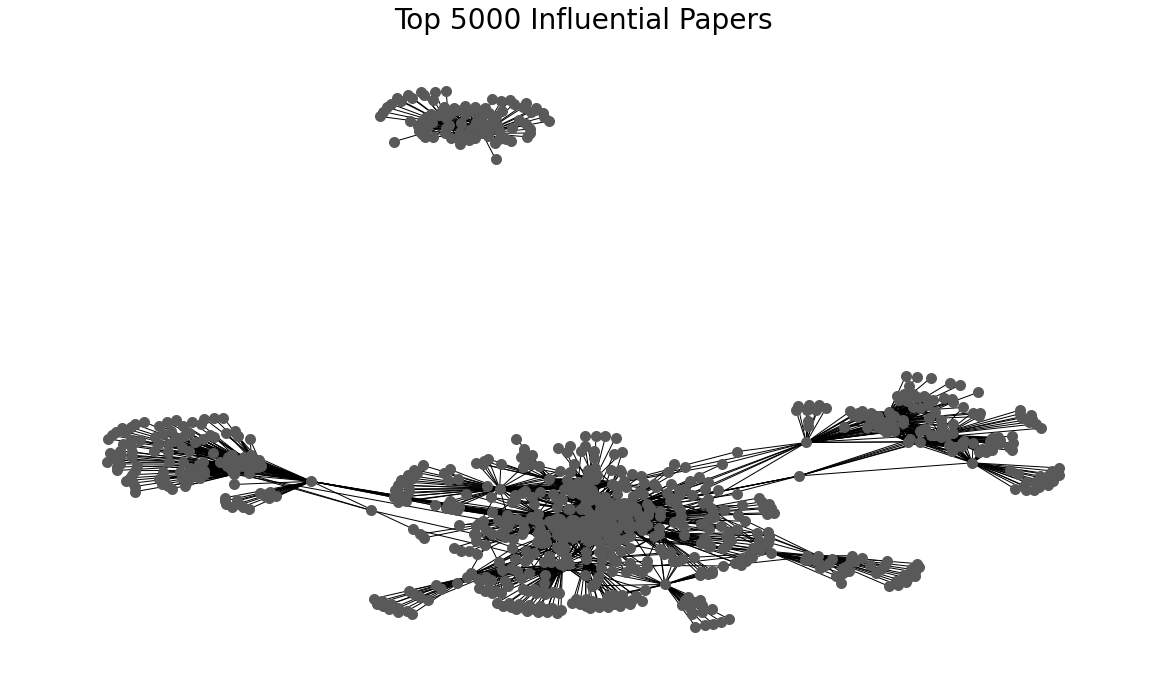

In [54]:
plt.figure(figsize=(16, 9))

pos = nx.nx_pydot.pydot_layout(well_connected_graph)
nx.draw(well_connected_graph, node_color="#595959", node_size=100, label=True)

plt.title("Top 5000 Influential Papers", fontsize=28)

plt.savefig("../images/network_well_connected_gr_5000_second", transparent=True)

In [56]:
# plt.figure(figsize=(16, 9))

# pos = nx.nx_pydot.pydot_layout(well_connected_graph)
# nx.drawing.draw_networkx(well_connected_graph, node_color="#595959", node_size=100, with_labels=True)

# plt.title("Top 5000 Influential Papers", fontsize=28)

# plt.savefig("../images/network_well_connected_labeled_5000_second", transparent=True)

Graph on 100000 initial samples is too large. Stream data and append to graph.

In [ ]:
plt.figure(figsize=(16, 9))

pos = nx.nx_pydot.pydot_layout(paper_author_paper)
nx.draw(paper_author_paper, pos=pos, node_color="#595959", node_size=100, label=True)

plt.title("Research Teams", fontsize=28)

plt.savefig("../images/network_graph_attempt_all_influencers", transparent=True)

In [57]:
#nx.write_gexf(paper_author_paper, "../models/graph_models/gephi_attempt.gexf")

In [58]:
# https://stackoverflow.com/questions/30821071/how-to-use-numpy-random-choice-in-a-list-of-tuples
lista_elegir = np.array(nd_ed_wg)
indices = np.random.choice(len(lista_elegir), 500)
array = lista_elegir[indices]
lst = np.ndarray.tolist(array)

In [64]:
nd_ed_wg_authors = [(condensed_matter["title"].iloc[i], condensed_matter["title"].iloc[j], k) for i, j, k in nd_ed_wg]

author_shared_author = nx.Graph()
author_shared_author.add_weighted_edges_from(nd_ed_wg_authors)

### StellarGraph to prepare graph for ML

In [73]:
stellar_pap = sg.StellarGraph.from_networkx(paper_author_paper)

In [70]:
random_biased_walks = sg.data.explorer.BiasedRandomWalk(graph=stellar_pap)

In [71]:
%%time
rbw = random_biased_walks.run(nodes=stellar_pap.nodes(), n=10, length=10, p=.5, q=2, weighted=True, seed=137)

Wall time: 13.6 s


In [74]:
# https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss
# The documentation for gensim is hit or miss. In this case the implementation of callbacks is obfuscated
class callback(callbacks.CallbackAny2Vec):

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subbed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subbed
        self.loss_to_be_subbed = loss
        print(f"Loss after epoch {self.epoch}: {loss_now}")
        self.epoch += 1

In [75]:
# word2vec takes random walks as sentences, expressions about the grammar/the structure of the graph.

weighted_model = Word2Vec(
    sentences=rbw, vector_size=128, alpha=.2, window=3, min_count=0, sg=1,
    workers=4, epochs=100, compute_loss=True, callbacks=[callback()]
)

In [84]:
# Similar neighborhoods/structures
weighted_model.wv.similar_by_key(24)

[(14673, 0.32608547806739807),
 (15617, 0.3173019289970398),
 (7318, 0.3109184801578522),
 (13573, 0.3075964152812958),
 (543, 0.3056521415710449),
 (276, 0.3056274950504303),
 (13634, 0.3033902645111084),
 (14935, 0.30289191007614136),
 (16285, 0.30025142431259155),
 (3397, 0.299866259098053)]

This is where I leave the preprocessing of data for a GAT currently. Relations should be generated with more meaningful features than papers by greatest number of shared collaborators.

I was trying to cluster in-groups/social groups whether from geography, prestige, or field. Better measures can be made.

Work in progress. I expect to include at least some amount latent features or at text representation by next month's end.